In [35]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statistics
import math
import warnings

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from math import hypot
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from statistics import mode

warnings.filterwarnings("ignore")
%matplotlib inline

# EDA

In [36]:
#получение данных из источника, проверка полей и исключение заведомо бесполезных для моделирования

data = pd.read_csv('/home/dataengineer/OTUS_ML/OTUS_ML_notebooks/data/AB_NYC_2019.csv')
data = data.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [37]:
#получение базовых статистик

data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


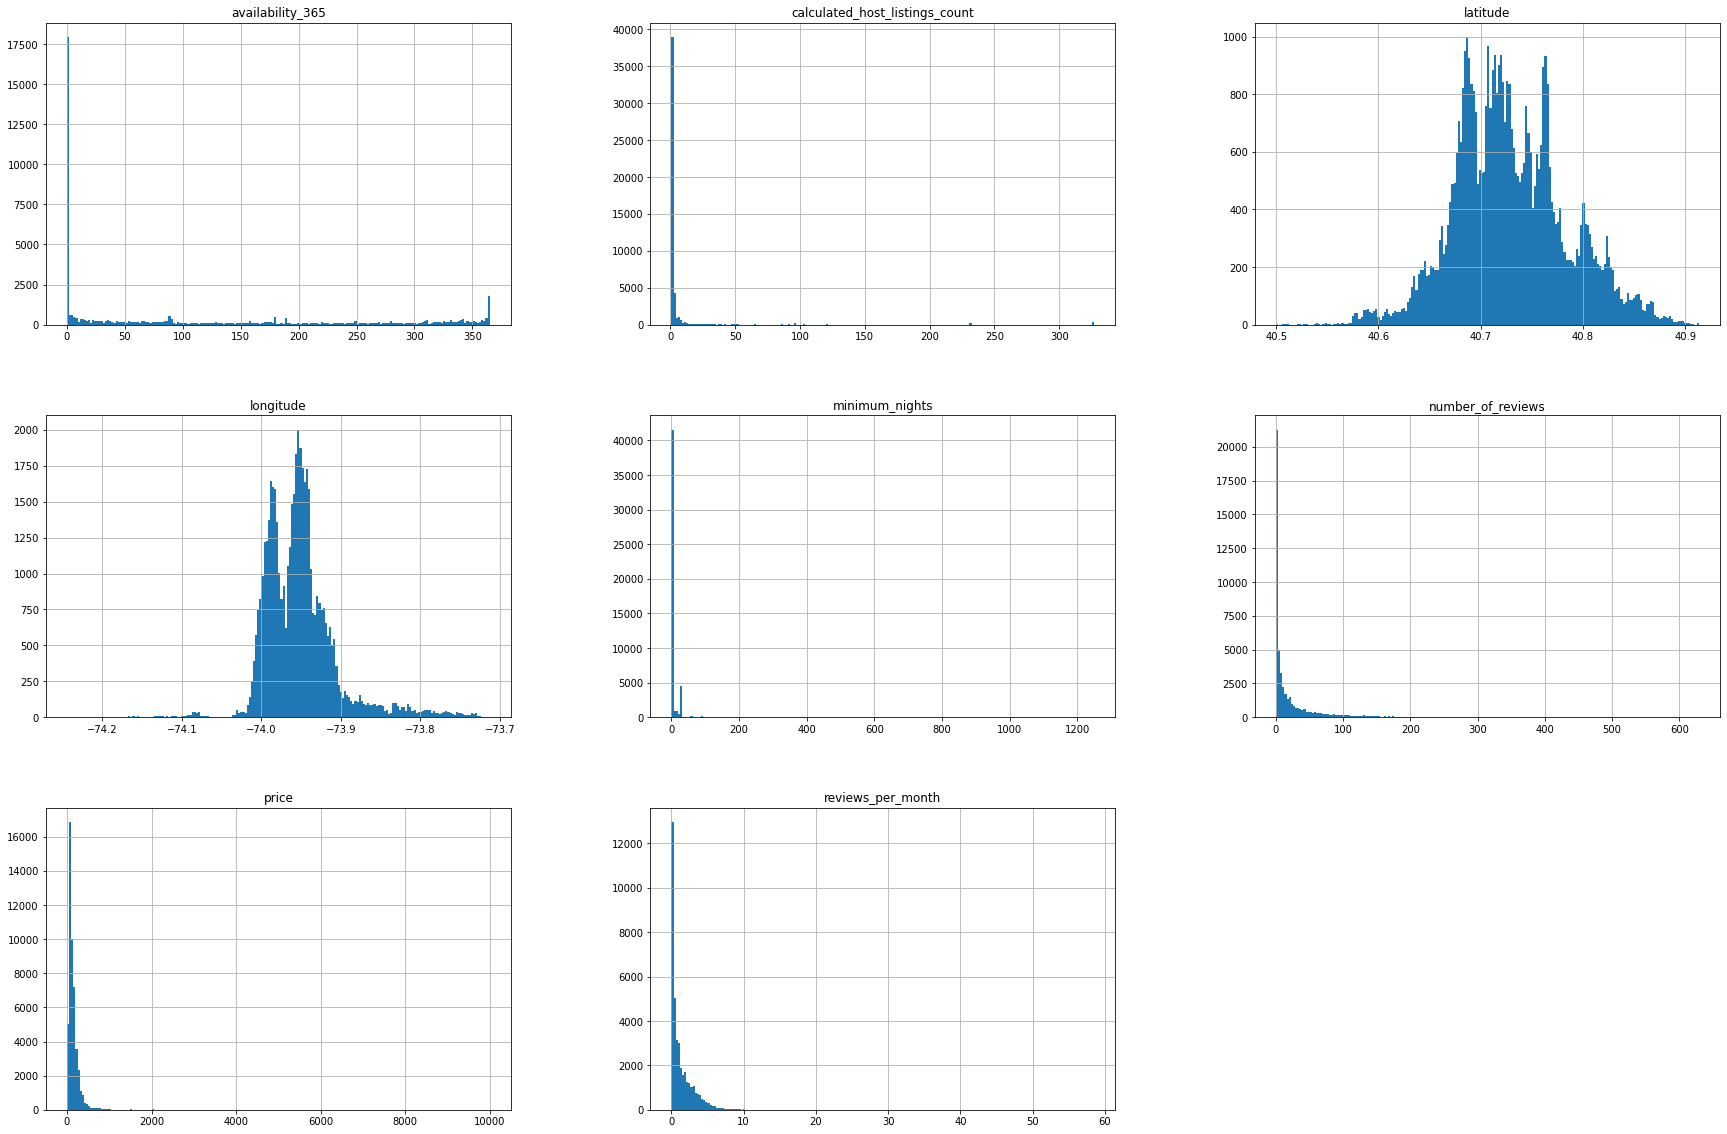

In [38]:
#построение гистограмм для оценки распределения переменных

data.hist(figsize=(30, 20), bins=200);

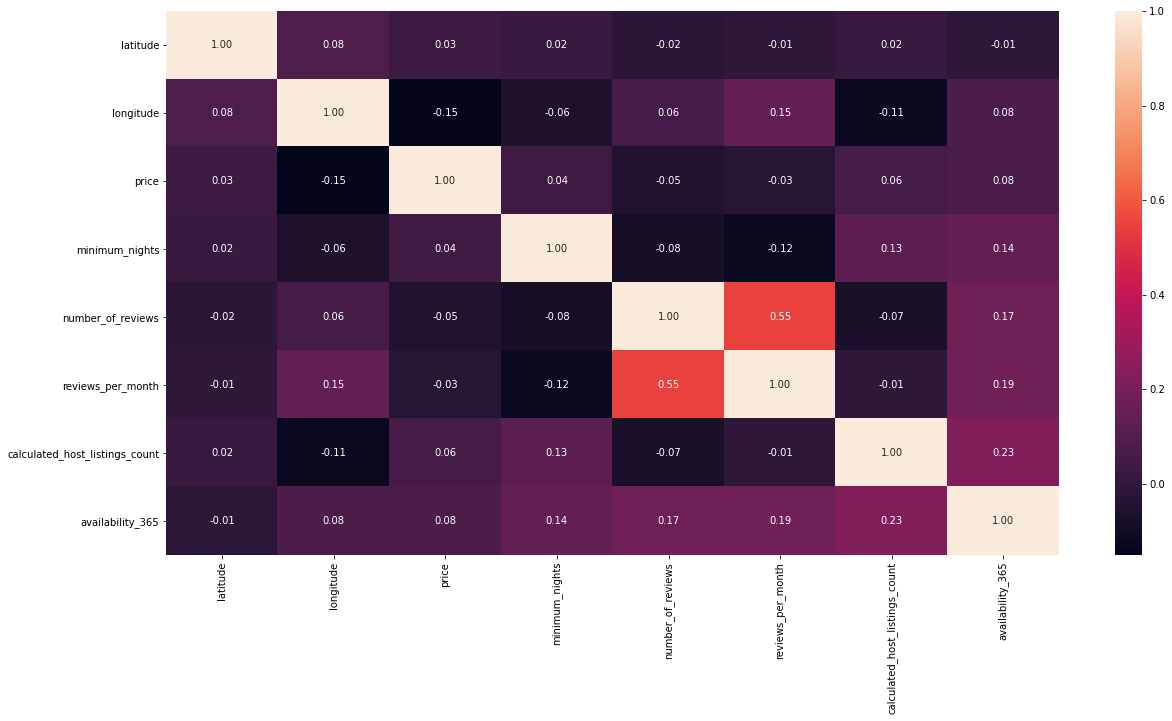

In [39]:
#построение heatmap для оценки корреляции признаков

Corr = data.corr()
plt.figure(figsize=(20,10));
sns.heatmap(Corr, annot=True, fmt='.2f');

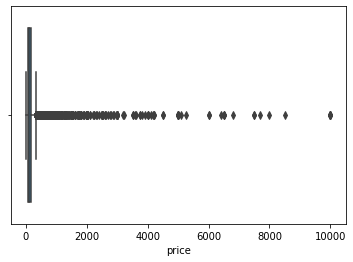

In [40]:
#построение boxplot для оценки распределения целевой переменнной

sns.boxplot(y=data['price'], orient = "h")

# Базовая предобработка и построение моделей

In [41]:
#метрики качества

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):
    stats = [
       mean_absolute_error(y_test, y_pred),
       mean_squared_error(y_test, y_pred),
       np.sqrt(mean_squared_error(y_test, y_pred)),
       r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats
measured_metrics = pd.DataFrame({"error_type":["MAE", "MSE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
MSE
RMSE
R2
MAPE


In [42]:
#удаление строк, содержащих нулевое значение целевой переменной (количество несущественное)

data_prep = data.loc[data['price'] > 0]

In [43]:
#заполнение пропусков в поле reviews_per_month нулями

data_prep['reviews_per_month'].fillna(0, inplace=True)

In [44]:
#one-hot кодирование категориальных переменных

data_prep = pd.get_dummies(data_prep, columns=['room_type', 'neighbourhood_group'])

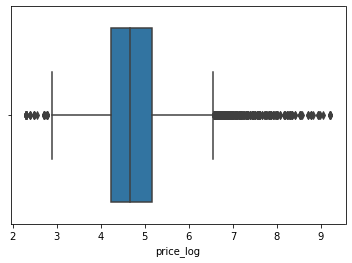

In [45]:
#логарифмирование целевой переменной

data_prep_0 = data_prep.copy(deep=True)

data_prep_0['price_log'] = np.log(data_prep_0['price'])
data_prep_0['price_log'].fillna(0, inplace=True)

data_prep_0.drop(['price'], axis=1, inplace=True)

sns.boxplot(y=data_prep_0['price_log'], orient = "h")

In [46]:
#разделение выборки на тренировочную и тестовую

y_0 = data_prep_0.price_log
X_0 = data_prep_0.drop('price_log', axis=1)
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.3, random_state=42)

In [47]:
#частотное кодировнаие категориальных переменной neighbourhood

X_train_0['neighbourhood_encoded'] = X_train_0['neighbourhood'].map(X_train_0['neighbourhood'].value_counts(normalize=True))
X_test_0['neighbourhood_encoded'] = X_test_0['neighbourhood'].map(X_test_0['neighbourhood'].value_counts(normalize=True))

X_train_0.drop(['neighbourhood'], axis=1, inplace=True)
X_test_0.drop(['neighbourhood'], axis=1, inplace=True)

In [48]:
#стандартизация

sc_0 = StandardScaler()
X_train_0_sc = sc_0.fit_transform(X_train_0)
X_test_0_sc = sc_0.transform (X_test_0)

In [49]:
#построение базовой модели RidgeCV

rcv_0 = RidgeCV()
rcv_0.fit(X_train_0_sc, y_train_0)
y_pred_rcv_0 = rcv_0.predict(X_test_0_sc)

measured_metrics["RidgeCV_0"] = dataframe_metrics(y_test_0, y_pred_rcv_0)

In [50]:
#построение базовой модели LassoCV

lcv_0 = LassoCV()
lcv_0.fit(X_train_0_sc, y_train_0)
y_pred_lcv_0 = lcv_0.predict(X_test_0_sc)

measured_metrics["LassoCV_0"] = dataframe_metrics(y_test_0, y_pred_lcv_0)

In [51]:
#построение базовой модели ElasticNetCV

encv_0 = ElasticNetCV()
encv_0.fit(X_train_0_sc, y_train_0)
y_pred_encv_0 = encv_0.predict(X_test_0_sc)


measured_metrics["ElasticNetCV_0"] = dataframe_metrics(y_test_0, y_pred_encv_0)
measured_metrics

,error_type,RidgeCV_0,LassoCV_0,ElasticNetCV_0
0,MAE,0.362748,0.362696,0.362692
1,MSE,0.245912,0.245894,0.245893
2,RMSE,0.495895,0.495877,0.495876
3,R2,0.488322,0.488358,0.488361
4,MAPE,7.680685,7.679798,7.679760


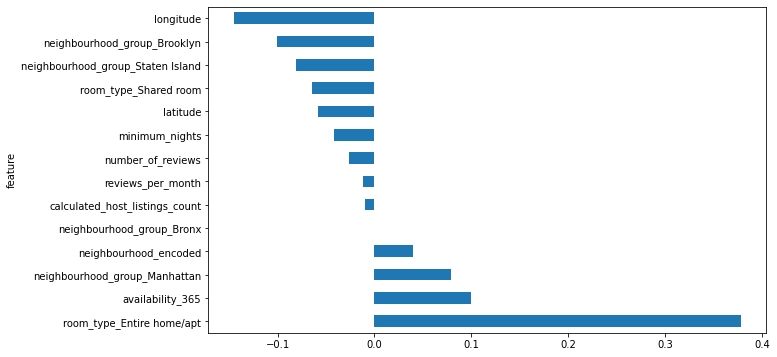

In [52]:
#оценка значимости переменных, выбранных LassoCV

featureImportance = pd.DataFrame({"feature": X_train_0.columns[lcv_0.coef_!=0], 
                                  "importance": lcv_0.coef_[lcv_0.coef_!=0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='barh', figsize=(10, 6));

# Улучшение качества моделей

In [53]:
#новая переменная - расстояние до Манхеттена

lat_base = 40.7834 #data.loc[data['neighbourhood_group'] == 'Manhattan', 'latitude'].mean()
long_base = -73.9662 #data.loc[data['neighbourhood_group'] == 'Manhattan', 'longitude'].mean()

data_prep_1 = data_prep.copy(deep=True)

data_prep_1['dist_to_Mhtn'] = data_prep_1.apply(lambda row: hypot(row.latitude - lat_base, row.longitude - long_base), axis = 1)

data_prep_1.drop(['longitude', 'latitude'], axis=1, inplace=True)

In [54]:
#разделение переменной minimum_nights на категориальные по диапазонам значений

def value_by_rng(n):
    
    if 1 <= n <= 3:
        name = '1-3'
    elif 4 <= n <= 7:
        name = '4-7'
    elif 8 <= n <= 14:
        name = '8-14'
    elif 15 <= n <= 30:
        name = '15-30'           
    else:
        name = '>30'
        
    return name


data_prep_1['min_nights'] = data_prep_1.apply(lambda row: value_by_rng(row.minimum_nights), axis = 1)
data_prep_1 = pd.get_dummies(data_prep_1, columns=['min_nights'])

data_prep_1.drop(['minimum_nights'], axis=1, inplace=True)

In [55]:
#новая переменная - количество месяцев, в течение которых размещались отзывы

def months_of_reviews(number_of_reviews, reviews_per_month):
    
    if reviews_per_month ==0:
        months_of_reviews = 0
    else:
        months_of_reviews = number_of_reviews / reviews_per_month
        
    return months_of_reviews   


data_prep_1['months_of_reviews'] = data_prep_1.apply(lambda row: months_of_reviews(row.number_of_reviews, row.reviews_per_month), axis = 1)

In [56]:
#новая переменная - доступность аредны на момент сбора данных

def is_available(value):
    
    if value == 0:
        is_available = 0
    else: 
        is_available = 1
        
    return is_available    

data_prep_1['is_available'] = data_prep_1.apply(lambda row: is_available(row.availability_365), axis = 1)

In [57]:
#разделение переменной calculated_host_listings_count на категориальные по диапазонам значений

def host_listings(value):
    
    if value <= 1:
        host_listings = '=1'
    elif value == 2: 
        host_listings = '=2'
    elif value == 3: 
        host_listings = '=3'
    elif value == 4: 
        host_listings = '=4'
    elif value == 5: 
        host_listings = '=5'        
    else:
        host_listings = '>5'
        
    return host_listings  


data_prep_1['host_listings'] = data_prep_1.apply(lambda row: host_listings(row.calculated_host_listings_count), axis = 1)
data_prep_1 = pd.get_dummies(data_prep_1, columns=['host_listings'])
data_prep_1.drop(['calculated_host_listings_count'], axis=1, inplace=True)

In [58]:
#логарифмирование непрерывных переменных, включая целевую

data_prep_1['reviews_per_month_log'] = np.log(data_prep_1['reviews_per_month']+1)
data_prep_1['reviews_per_month_log'].fillna(0, inplace=True)

data_prep_1['number_of_reviews_log'] = np.log(data_prep_1['number_of_reviews']+1)
data_prep_1['number_of_reviews_log'].fillna(0, inplace=True)

data_prep_1['months_of_reviews_log'] = np.log(data_prep_1['months_of_reviews']+1)
data_prep_1['months_of_reviews_log'].fillna(0, inplace=True)

data_prep_1['price_log'] = np.log(data_prep_1['price'])
data_prep_1['price_log'].fillna(0, inplace=True)

data_prep_1.drop(['reviews_per_month', 'number_of_reviews', 'months_of_reviews', 'price'], axis=1, inplace=True)

In [59]:
#availability_365 - замена нулей на моду

availability_mode = mode(data_prep_1.loc[data_prep_1['availability_365']>0, 'availability_365'])

def remove_zero(value, new_value):
    if value == 0: 
        value = new_value
    else:
        value
    return value    
        
data_prep_1['availability_365'] = data_prep_1.apply(lambda row: remove_zero(row.availability_365, availability_mode), axis = 1)

In [60]:
#кодирование переменной neighbourhood

labelencoder = LabelEncoder()
data_prep_1['neighbourhood_encoded'] = labelencoder.fit_transform(data_prep_1['neighbourhood'])
data_prep_1.drop(['neighbourhood'], axis=1, inplace=True)

In [61]:
#разделение выборки на тренировочную и тестовую

y_1 = data_prep_1.price_log
X_1 = data_prep_1.drop('price_log', axis=1)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=42)

In [63]:
#стандартизация

sc_1 = StandardScaler()
X_train_1_sc = sc_1.fit_transform(X_train_1)
X_test_1_sc = sc_1.transform (X_test_1)

In [64]:
#построение модели RidgeCV на дополнительно обработанных данных

rcv_1 = RidgeCV()
rcv_1.fit(X_train_1_sc, y_train_1)
y_pred_rcv_1 = rcv_1.predict(X_test_1_sc)

measured_metrics["RidgeCV_1"] = dataframe_metrics(y_test_1, y_pred_rcv_1)

In [65]:
#построение модели LassoCV на дополнительно обработанных данных

lcv_1 = LassoCV()
lcv_1.fit(X_train_1_sc, y_train_1)
y_pred_lcv_1 = lcv_1.predict(X_test_1_sc)

measured_metrics["LassoCV_1"] = dataframe_metrics(y_test_1, y_pred_lcv_1)

In [66]:
#построение модели ElasticNetCV на дополнительно обработанных данных

encv_1 = ElasticNetCV()
encv_1.fit(X_train_1_sc, y_train_1)
y_pred_encv_1 = encv_1.predict(X_test_1_sc)


measured_metrics["ElasticNetCV_1"] = dataframe_metrics(y_test_1, y_pred_encv_1)
measured_metrics = measured_metrics[['error_type' ,'RidgeCV_0' ,'RidgeCV_1' ,'LassoCV_0' ,'LassoCV_1' , 'ElasticNetCV_0', 'ElasticNetCV_1']]
measured_metrics

,error_type,RidgeCV_0,RidgeCV_1,LassoCV_0,LassoCV_1,ElasticNetCV_0,ElasticNetCV_1
0,MAE,0.362748,0.359213,0.362696,0.359176,0.362692,0.359169
1,MSE,0.245912,0.239856,0.245894,0.239853,0.245893,0.239854
2,RMSE,0.495895,0.489751,0.495877,0.489748,0.495876,0.489748
3,R2,0.488322,0.500923,0.488358,0.500929,0.488361,0.500927
4,MAPE,7.680685,7.609949,7.679798,7.609363,7.679760,7.609257


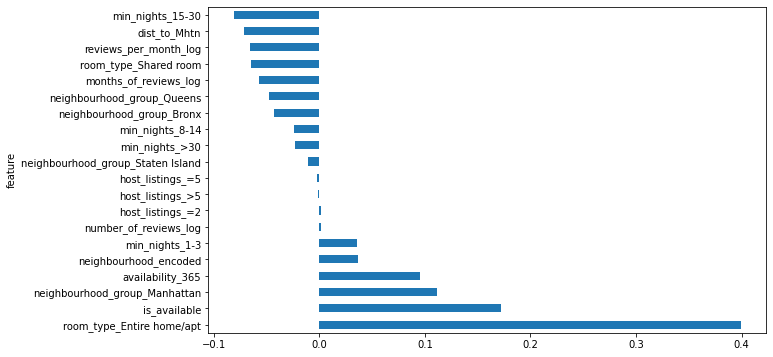

In [67]:
#оценка значимости переменных, выбранных LassoCV на дополнительно обработанных данных

featureImportance = pd.DataFrame({"feature": X_train_1.columns[lcv_1.coef_!=0], 
                                  "importance": lcv_1.coef_[lcv_1.coef_!=0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='barh', figsize=(10, 6));